# Introduction 
- Outlining the Objective
- Background Information

<b><u>Objective :</u></b> Can machine learning be applied to chemical analysis of wine to identify where it was produced?

The chemisty of wine is influenced by many factors throughout several stages of the wine-making process. Discrete molecules, making up around 3% of the wine (the other 97% being water and ethanol), make each batch distinct. For instance, chemical activity during the fermentation process, maturing, bottling and even pouring all have their effects. Importantly, it is of course influenced by the soil the grapes in the vineyards grew in [3]. Therefore, perhaps an in depth analysis of the chemcial make-up of wines can be used to identify where the wines originate from. There are many potential benefits to doing this. For instance, wine is a popular and lucrative good amongst collectors, sellers and other luxery buyers. As a consquence, there is plenty of wine fraud attempting to capitalise on this. It can be as simple as falsly labelling the origin of wine, false historical relevance, and mixing wines (or watering it down). Consequently, correctly identifying the origin of the wine through chemical analysis is important validating claims [4]. Applying machine learning algorithms to this validation step could be beneficial if it proves to be accurate.  

In this notebook, we will explore the potential of applying machine learning to identifying the origins of wine from three culivars. We will explore the data to find any trends or interesting features, and then apply different models to the problem, namely two supervised models being a decision tree and k-nearest-neighbour model, and one unsupervised model being kmeans clustering. We will analyse and compare the results in order to determine which will be the best for use cases such as assisting to prevent wine fraud. 


## Imported Libraries


In [1]:
# Data Manipulation
import numpy as np
import pandas as pd

# Data Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from IPython.display import display
from sklearn.decomposition import PCA

# Model Implementation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

# Model Evaluation
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix, silhouette_score
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold, cross_val_score

# Data Description 

For this notebook, we will be using data already collected and available. The data set [1] contains the results of a chemical analysis of wines from three different cultivars all found in the same region in Italy, and is made up of 13 continuous real and integer attributes, with 1 additional "Target" attribute which identifies the wine's origins. There are 178 instances that make up the whole dataset. An unfortunate limitation of this dataset is that the units for the attributes are not specified, which is not particularly helpful when we might wish to collect further data to use for future research. Most likely they follow the typical units, but we cannot be sure of that. 

A description of each attribute follows: 
1. Target (either 1, 2 or 3)

2. Alcohol (Likely percentage content) 

3. Malic acid (Linked to the sourness of a wine, and its concentration decreases the more a grape ripens [6]. Typical malic acid content in wine can fall between 0 and 8,000 mg/L [7]).

4. Ash (Inorganic matter that remains after evaporation and incineration, including trace minerals, such as Aluminium, and cations, like potassium, sodium and copper. Typical content of ash in wines is about 2.5g/L [8])

5. Alcalinity of ash (Sum of the cations, other than the ammonium ion, combined with organic acids found in the wine [9])
6. Magnesium (Included in trace minerals found in wine. Typical values of are around 114 mg/L [10])

7. Total phenols (These affect the bitterness and astrigency of wine, especially red, and consist of flavanoids and nonflavanoids (as well as proanthocyanins). A typical glass of red wine may contain around 200mg of phenols, whereas white is around 40mg [11])

8. Flavanoids

9. Nonflavanoid phenols

10. Proanthocyanins

11. Color intensity (Refers to the wine's opacity. This can differ with grape variety and is influenced by polyphenols, temperature and age [12])
12. Hue (Comes from the skins of the grapes. A deeper hue may suggest a lower pH/higher acidity [12])

13. OD280/OD315 of diluted wines (Method of determining the protein concentration in wines [13])

14. Proline (Main amino acid in red wines [13])

Interestingly, the original data had 30 attributes, but this dataset is reduced. The other attributes are unknown, but it may have given better insight into the levels of other metals other than magnesisum, which are of particular note when identifying wines from multiple countries [3].

This dataset is a popular choice for experimentation with models as the dataset is "'well behaved' class structures"[1], although it is not challenging. Because of this, we can potentially compare the models created in this notebook to those created by others to compare results and identify any potential areas the models presented in this notebook might be improved. 

## Loading in the Data

To begin, we will load in the data. The file does not contain any column names so these will be added for easier manipulation.

We will also split the data into its features, the 13 real and integer attributes, and labels, being the cultivars of origin.


In [2]:
# Column headers
headers = ["Target", "Alcohol", "Malic Acid", "Ash", "Alcalinity of Ash", "Magnesium", "Total Phenols", "Flavanoids",
            "Nonflavanoid Phenols", "Proanthocyanins", "Color Intensity", "Hue", "OD280/OD315 of diluted wines", "Proline"]


# Read data into data frame
wine_frame = pd.read_csv("wine.csv", names=headers)

# Splitting the data into feature frame and label frame
X = wine_frame.drop(['Target'], axis=1)
y = wine_frame['Target']

A look at the actual data:

In [3]:
# Display the dataset
display(wine_frame)

# Check for any missing values 
wine_frame.isnull().sum()

,Target,Alcohol,Malic Acid,Ash,Alcalinity of Ash,Magnesium,Total Phenols,Flavanoids,Nonflavanoid Phenols,Proanthocyanins,Color Intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,3,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740
174,3,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750
175,3,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835
176,3,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840


Target                          0
Alcohol                         0
Malic Acid                      0
Ash                             0
Alcalinity of Ash               0
Magnesium                       0
Total Phenols                   0
Flavanoids                      0
Nonflavanoid Phenols            0
Proanthocyanins                 0
Color Intensity                 0
Hue                             0
OD280/OD315 of diluted wines    0
Proline                         0
dtype: int64

From this, we notice that the data is not random and sorted into each cultivar, so we will need to shuffle this data to have effective train and test data for the models. However, we also notice there is no missing values and it is complete, so there is no need to worry about that. On the other hand, looking at the data in this way makes it hard for us to see the variance in each attribute and notice any outliers.

# Exploratory Analysis

## Pie and Bar Chart

- Detailing the proportion of wines from each cultivar:

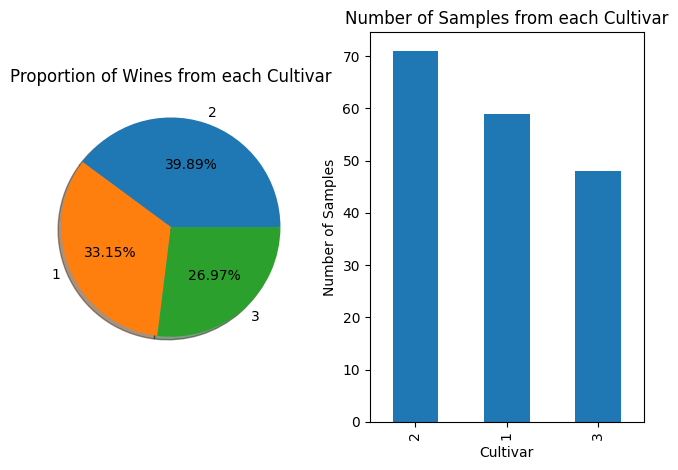

In [4]:
# Pie Chart
plt.subplot(1,2,1)
plt.pie(y.value_counts(),
        labels=["2", "1", "3"],
        autopct="%.2f%%",
        shadow=True)
plt.title("Proportion of Wines from each Cultivar")

# Bar Chart
plt.subplot(1,2,2)
y.value_counts().plot.bar()
plt.title("Number of Samples from each Cultivar")
plt.ylabel("Number of Samples")
plt.xlabel("Cultivar")

plt.tight_layout()
plt.show()


We can see that each cultivar has a decent sample from each. Cultivar 2 makes up the most of the dataset, at 39.89%, or 71 data points, and Cultivar 3 makes up the fewest data points in the dataset at 26.97%, but still has a good sample of 48 instances. Culivar 1 falls roughly in the middle of these two amounts with 59 instances (or 33.15%).

As a result, we can be sure that the models we create from this dataset will have a good amount of data from each cultivar to have the potential to be effective. Of course, more instances from Cultivars 1 and 3 would be even better to have an even spread of data across all 3 and, undoubtedly, more instances overall would be preferable to make our models later on much more accurate, but 178 is reasonable.

## Box and Whisker Graph

- The distribution of each attribute and spotting any outliers

A boxplot will show us the distribution of each attribute in the data. However, they all have different scales, so we shall standardise the data so we can more easily see this. We will also use this standardisation of data a lot throughout to prevent the models being influenced heavily by one attribute.

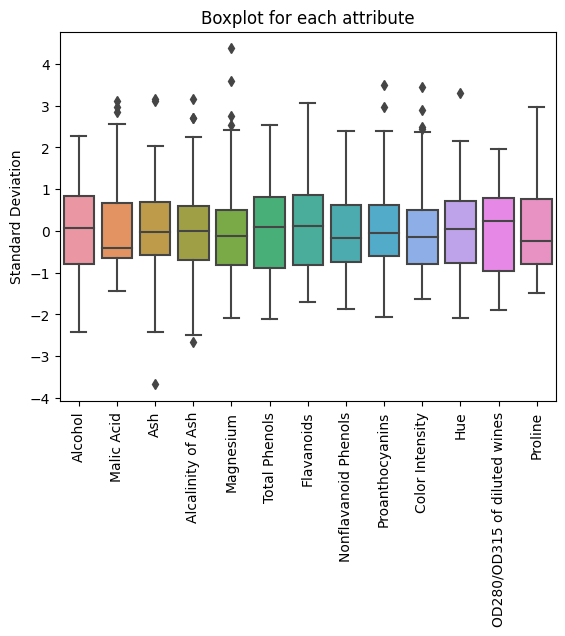

In [5]:
# Standardisation of data
scaler = StandardScaler()
X_headers = ["Alcohol", "Malic Acid", "Ash", "Alcalinity of Ash", "Magnesium", "Total Phenols", "Flavanoids",
            "Nonflavanoid Phenols", "Proanthocyanins", "Color Intensity", "Hue", "OD280/OD315 of diluted wines", "Proline"]
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X_headers)

# Boxplot
box_plot = sns.boxplot(X_scaled)
box_plot.set_xticklabels(box_plot.get_xticklabels(), rotation=90)
plt.ylabel("Standard Deviation")
plt.title("Boxplot for each attribute")
plt.show()

From the boxplot, it's immediately obvious to see the outliers in some of our attributes. For example, Hue has one noteable outlier, and Malic Acid and Magnesium have several. This is in comparsion to Proline, Alcohol, Total Phenols, Flavanoids, Nonflavanoid phenols and 0D280/0D315 of diluted wines which do not have any outliers according to this. Considering this, it will be interesting to see how much these might effect our models later on, possibly resulting in inaccurate predictions, revealing how effective our models will be with real, unseen data.   

Additionally, most attributes have a median similar to the mean and generally appear to have an even spread of values above and below the mean. Proline and Malic Acid appear to have a greater spread of values above the mean, whereas OD280/OD315 of diluted wines has a greater spread of values below the mean. These may be features of note that help distinguish each cultivar as it may be that the samples from a cultivar are considerably different to the others, which may aid to reduce the dimensionality of the dataset to better visualise it.   

## Closer Look 
- Using Scatter graphs to visualise Proline, Malic Acid, Magnesium and OD280/OD315 of diluted wines

A scatter matrix of Proline, Malic Acid and OD280/OD315 of diluted wines, as identified from the box and whisker graph, will be visualised to see if these attributes to possibly identify any clustering in the datapoints. Magnesium has also been included due to different metal content in wines already being used to identify wines so it might be prudent to establish how much of influence it may have also. 

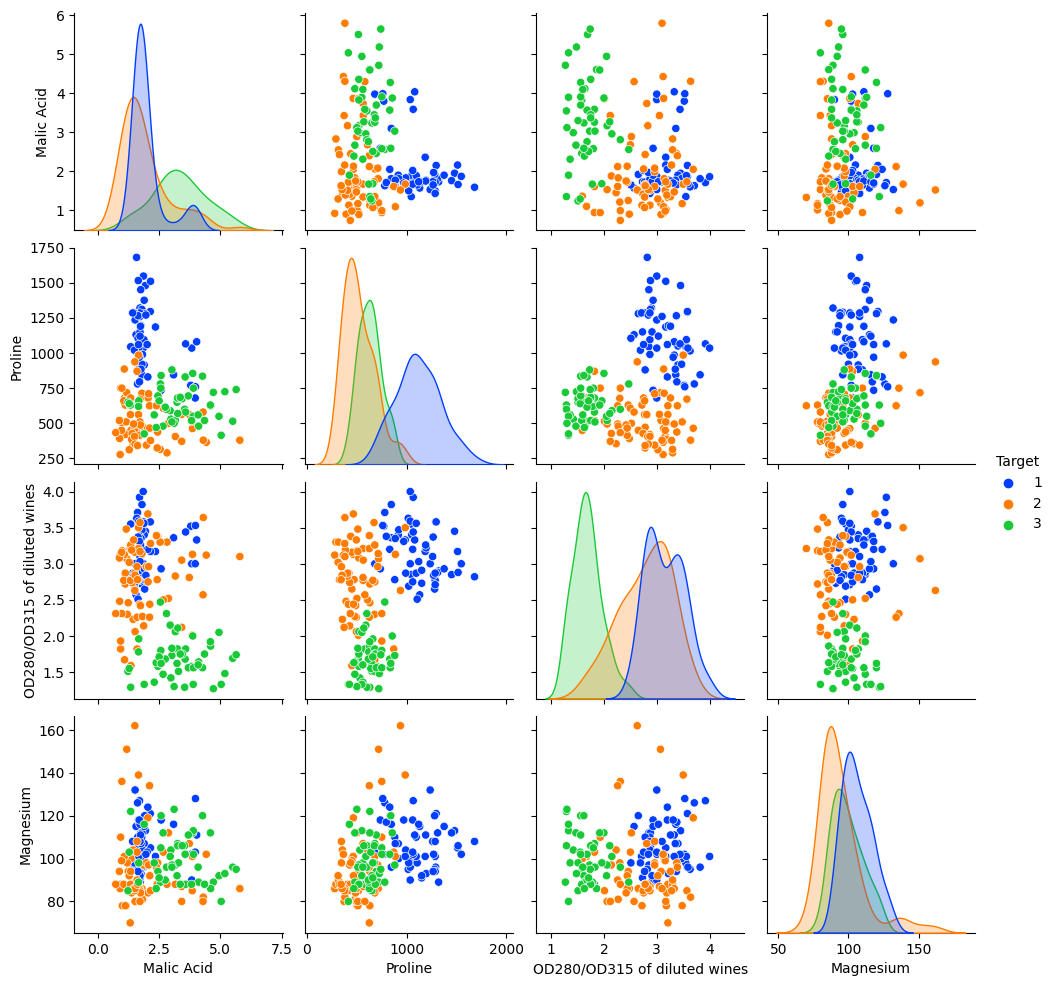

In [6]:
# Scatter Matix of Malic Acid, Proline, OD280/OD315 of diluted wines and Magnesium
sns.pairplot(wine_frame[["Malic Acid", "Proline", "OD280/OD315 of diluted wines", "Magnesium", "Target"]],
             hue='Target',
             palette=sns.color_palette("bright", 3))
plt.show()

First of all, magnesium is quite disappointing as there appears to be a lot of overlap between each cultivar. Being paired with Proline and OD280/OD315 of diluted wines are clearer than Malic acid: Proline has a reasonably clear cluster for cultivar 1, and OD280/OD315 of diluted wines for cultivar 3, but the other two cultivars are very similar in both cases. Malic Acid and OD280/OD315 of diluted wines has reasonable clusters of data but 2 and 3 share a lot of overlap. Proline and OD280/OD315 of diluted wines, however, show clear, distinct clusters, with only a few overlapping datapoints, which is promising for the models later on. Perhaps other features will be able to identify these points and aid the models' accuracy. Otherwise, it can be used as a clear way to separate the datapoints into each cultivar. 

## Principal Component Analysis

- Reducing the dimensionality to clearly visualise and analyse the data

There are a lot of attributes to analyse as part of this dataset and visualising all would be hard to discern. We have already had a look at some features of note, but this could likely miss out other features that may be useful to investigate. Consequently, we shall use Principal Component Analysis to reduce the dimensionality of the data whilst still capturing a good proportion of the variance.

To ensure that PCA model captures the variance in the data effectively, we will use the standardised data again.

In [7]:
# PCA Model

pca_model = PCA()
pca_transformed = pca_model.fit_transform(X_scaled)


Below we create a graph that shows how much variance is retained when we use an increasing number of principal components:

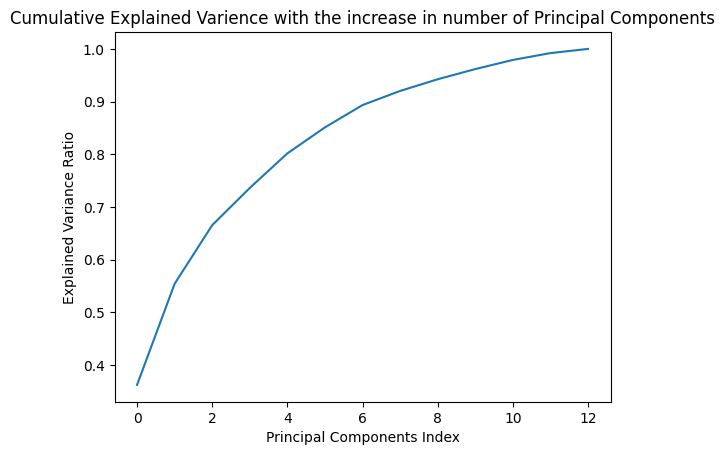

In [8]:
# Plotting the explained variance ratio
plt.plot(pca_model.explained_variance_ratio_.cumsum())
plt.ylabel("Explained Variance Ratio")
plt.xlabel("Principal Components Index")
plt.title("Cumulative Explained Varience with the increase in number of Principal Components")
plt.show()


From the graph, we can see that 2 principal components explains about 55.41% of the variance. This is reasonable, but theres plenty of data lost there. 3 components captures about 66.53%, which is better, but still means about 33.47% of data is not captured.

However, its clear that the variance explained does not dramatically exponentially decrease with increasing principal components. To capture above 99% of the varience, we would need 12 components, which hardly reduces the data at all. To capture above 90%, we would need 8 components, which is better, but still hard to visualise. This could indicate that most of the attributes within the dataset are useful and can potentially aid in identifying the wines origins, although some more than others. 

Despite all this, we will only do up to 3 dimensions as we can easily visualise that. 

### 2 Component Visualisation
- Scatter graph of the first two principal components

In [9]:
# Creating Data Frame from PCA model for visualisation

pca_df = pd.DataFrame(pca_transformed)
columns = []
for i in range(1, 14):
    columns.append("PC" + str(i))
pca_df.columns = columns
pca_df["Target"] = y
pca_df["Target"] = pca_df["Target"].astype(str)

# PCA 2D Visualisation
fig = px.scatter(pca_df, x='PC1', y='PC2', color='Target')
fig.show()

Even with 2 components capturing 55.41% of the varience, there's clear distinctions between the three cultivars. Each has their own cluster with minimal overlap, which could indicate that the data can be used to effectively identify the origin of the wines, but in a few cases may result in inaccurate predictions. For instance, we can see three data points from cultivar 2 are very similar to cultivar 1. These may be incorrectly predicted to be from cultivar 1, for example. Cultivar 1 and 3 appear to be the least in common, being very distinct from each other and have no overlapping datapoints. Cultivar 2, however, has instances fairly similar to both. This may prove to be an area of difficulty for the models.

### 3 Component Visualisation
- 3D scatter plot visualisation of the first 3 principal components

In [10]:
# PCA 3D Visualisation

fig = px.scatter_3d(pca_df, x='PC1', y='PC2', z='PC3', color='Target')
fig.show()

Using a 3D visualisation allows us to see the first three principal components of the data, capturing a better 66.53% of the variance. Using this, we can easily identify the clusters for each cultivar, even better than the 2D. We can also more noticeably identify any overlapping data points, which there are a few. Particularly, the overlapping datapoints are shared between 2 and either 1 or 3. In the 3D visualisation, we can confidently say that, according to this dataset, 1 and 3 are quite distinct from each other. 2 has its own cluster, which is easily idenfiable, but not as distinct.     

# Models

- Splitting our data, Implementing Models and Result Analysis

First of all, we shall split our data into training and testing data. As pointed out earlier, the data is not in a random order, so we will need to shuffle this data. To make this repeatable, I have specified a seed for the randomness of the shuffle. 80% of our original data will be used for testing and the other 20% for testing.

In [11]:
# Split the data into training data and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=66, shuffle=True, test_size=0.2)

# Scale the features
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


## Decision Tree Model

For this data, we know the correct targets so we can use supervised classification models. First of all, we shall see how well a decision tree model performs. 

### Implementation

- Implementing and training the model 

In [12]:
# Implementation of Decision Tree
decision_tree = DecisionTreeClassifier()
decision_tree = decision_tree.fit(X_train, y_train)

### Evaluation

- Confusion matrix, accuracy and analysis

We shall use a confusion matrix to visualise the accuracy of our model, comparing the true labels and the predicted labels. 

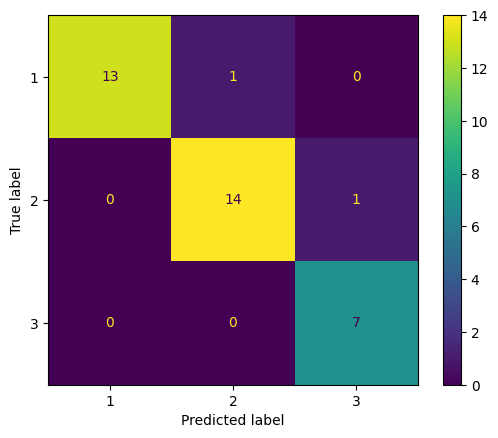

Decision Tree Accuracy: 94.44%


In [13]:
# Model Predictions
tree_predictions = decision_tree.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, tree_predictions, labels=decision_tree.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=decision_tree.classes_)
disp.plot()
plt.show()

# Accuracy
split_accuracy = accuracy_score(y_test, tree_predictions) * 100
print("Decision Tree Accuracy: %.2f%%" % split_accuracy)


With a 94.44% accuracy score, the decision tree model is really good at predicting the cultivars of origin with only a few errors. According to the confusion matrix, a wine from cultivar 2 was incorrectly predicted to originate from cultivar 3, and a wine from cultivar 1 labelled as 2. This is consistent with the areas of overlap identified earlier in the principal component analysis. However, this score may only have been an element of luck with the way the data was shuffled. Therefore, K-Fold cross validation will also be used to ensure that our model is truly accurate.

### K-Fold Cross Validation

Random Sampling:


In [14]:
# Repeated Random KFold
rand_kfold = RepeatedKFold(n_splits=10, random_state=165)

# Cross Validation For Mean Accuracy
scores = cross_val_score(decision_tree, X_scaled, y, cv=rand_kfold)
rand_kfold_score = scores.mean() * 100
print("Average score: %.2f%%" % rand_kfold_score)


Average score: 91.02%


Using random sampling K-Fold cross validation, the mean of our scores comes out to be around 91.02%, which is noteably worse than the train-test split of the data, and might imply that the train-test split is not a good representation of its accuracy. On the other hand, 91.02% is still really good. Despite repeating the K-Fold to limit the possible effect the random distribution, we will also do a stratified KFold to be sure of this result. 

Stratified Sampling:

In [15]:
# Repeated Stratified K-Fold
strat_kfold = RepeatedStratifiedKFold(n_splits=10)

# Cross Validation for Mean Accuracy
scores = cross_val_score(decision_tree, X_scaled, y, cv=strat_kfold)
strat_kfold_score = scores.mean() * 100
print("Average score: %.2f%%" % strat_kfold_score)

# All scores for comparison later
tree_eval_scores = [split_accuracy, rand_kfold_score, strat_kfold_score]

Average score: 90.11%


Here we can see that a stratified method has resulted in an average score of around 90.11%, similar the random sampling. Consequently, from this we can say that a decision tree is a reasonable model for predicting the origins of wine, although some improvement can still be made. In this implementation of the model, all attributes were included, which may not have been effective as some outliers were found and may have affected this model, which may be an area of improvement to explore in future work as we want to be as accurate as possible. Alternatively, other models may be better so we will implement and explore additional models and do similar evaluation techniques to compare them.

## K-nearest-neighbor Classification

As seen in the exploratory analysis, much of our data samples are very similar within each cultivar, making each fairly distinct from one another. Because of this, perhaps K-nearest-neighbour classification could be a suitable model to apply.

Implementation:

K-nearest-neighbour classification requires us to specify how many neighbours we would like to compare to. To find the optimal K, we will use a grid search for parameter hypertuning.

In [16]:
# Implementation of model
knn = KNeighborsClassifier()

# Dictionary of parameters we would like to test (value of K) 
param_grid = {'n_neighbors': np.arange(1, 25)}

# Testing all values for K
knn_gscv = GridSearchCV(knn, param_grid, cv=5)
knn_gscv.fit(X_scaled, y)

# Best value of K and score
print("Best number of neighbours: ", knn_gscv.best_params_)
knn_gscv_best_score = knn_gscv.best_score_ * 100
print("Best Score: %.2f%%" % knn_gscv_best_score)


Best number of neighbours:  {'n_neighbors': 7}
Best Score: 96.65%


According to the Grid Search, the optimal value of K is 7, achieving the best score of 96.65%, which is better than what was achieved by the decision tree model. This is very promising, but for a more direct comparision, we will do the same evalution techniques used earlier. 

### Confusion Matrix

- Evaluation and Comparison to Decision Tree

Similar to what we did for the decison tree, we will visualise a confusion matrix to compare the true labels and predicted labels obtained from the KNN model. We will specify the value of K to be 7.

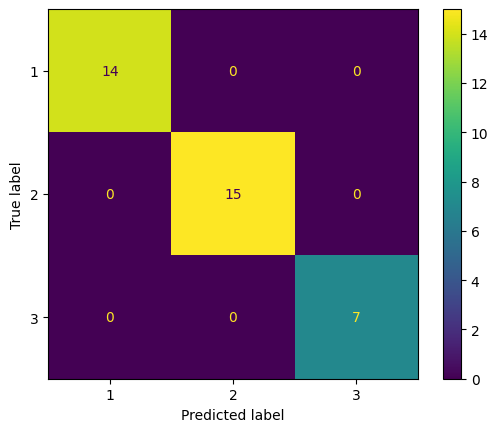

Accuracy Score: 100.00%


In [17]:
# Model Implementation
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)

# Model Predictions
knn_predictions = knn.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, knn_predictions, labels=knn.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=knn.classes_)
disp.plot()
plt.show()

split_accuracy = accuracy_score(y_test, knn_predictions) * 100
print("Accuracy Score: %.2f%%" % split_accuracy)

Using the same train-test split used for our decison tree, the KNN model achieved an accuracy score of 100%, which is outstanding and is obviously better than our decision tree, but we must be skeptical of this result. This model, in comparison to the decision tree model, was able to correctly predict the sample from cultivar 2 and 1. Sadly, this is using the same train-test split, which may only be due to luck we are achieving so well, similar to what we saw with the decision tree. This test achieving better than our grid search might similarly suggest this. As such, we will again perform a K-Fold cross validation to really put this model to the test.  

### K-Fold Cross Validation

Random Sampling:

In [18]:
# Repeated Random K-Fold Score
scores = cross_val_score(knn, X_scaled, y, cv=rand_kfold)
rand_kfold_score = scores.mean() * 100
print("Mean Accuracy: %.2f%%" % rand_kfold_score)

Mean Accuracy: 97.08%


At 97.08% accuracy, the random K-Fold determined our model to be slightly less accurate than what our train-test evalution led us to be believe, and is more in line with what the grid search determined. It still suggests that this model is really good and more accurate than the decision tree model. However, for consistency, we will again do the stratified method. 

Stratified Sampling:

In [19]:
# Repeated Stratified K-Fold Score
scores = cross_val_score(knn, X_scaled, y, cv=strat_kfold)
strat_kfold_score = scores.mean() * 100
print("Mean Accuracy: %.2f%%" % strat_kfold_score)

# All Scores 
knn_eval_scores = [split_accuracy, rand_kfold_score, strat_kfold_score]

Mean Accuracy: 96.61%


The stratified strategy concurs with our random folds (although slightly worse at 96.88%), and therefore the grid search. The train-test split is clearly not an accurate representation. Despite that, we can definitively say that this method is more accurate than our decision tree model given this dataset. 

### Decision Tree vs KNN
- Visual comparison and summary of scores

Here is a visual comparison of the scores. Much comparison has already been done, but here is a summary of the findings between the two supervised models.

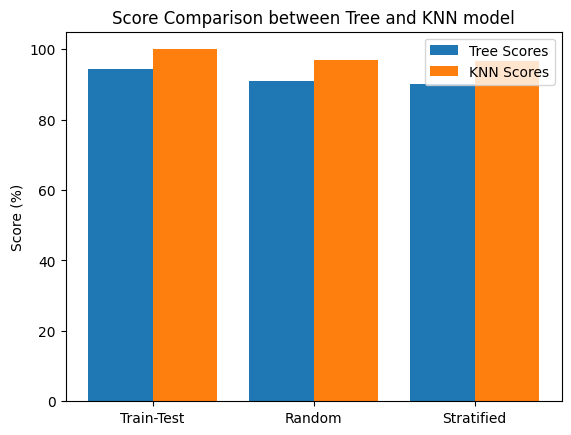

In [20]:
# Creating bar chart for comparison between tree and knn scores
ind = np.arange(3) 
width = 0.40       
plt.bar(ind, tree_eval_scores, width, label='Tree Scores')
plt.bar(ind + width, knn_eval_scores, width,
    label='KNN Scores')

plt.ylabel('Score (%)')
plt.title('Score Comparison between Tree and KNN model')

plt.xticks(ind + width / 2, ('Train-Test', 'Random', 'Stratified'))
plt.legend(loc='best')
plt.show()

A visual representation of the comparison of scores achieved by the tree and knn model easily let's us see that the 7NN model performs much better than the tree model across all evaluation scores (approximately about 7% better), even though the decision tree performs really well (both did exceptionally well with the train-test split, showing that it may be a generous representation of the accuracy, but not too far off). As a result, we can determine that a 7-nearest-neighbour is an appropriate, highly accurate model as a possible solution to the problem, and using the decision tree model would prove to be obsolete. It may be the case that the areas of overlap and outliers had a greater effect on the decison tree, whereas the 7NN model mitigated their effects. Undoubtedly, with more datapoints and regions of origin, it might display limitations of using this model. Perhaps some adjustment would need to be made or other models might be more appropriate in future work. 

## K-Means Clustering Model


The wine dataset has the correct labels given already in the data, and, appropriately, we have used supervised models. However, it might be interesting to see how well an unsupervised model performs. We could see in the exploratory analysis that the data forms good, clear clusters, so perhaps a K-means model might perform well. We will specify that the number of clusters we are looking for will be 3 as we only want 3 labels. 

### Implementation

In [21]:
# K Means Clustering model 
kmeans = KMeans(n_clusters=3, n_init='auto')
kmeans.fit(X_train)


KMeans(n_clusters=3, n_init='auto')

### Quality of clusters

- Using scatter graph to visualise performance of clusters 
- Using silouhette score to quantify the clarity of clusters

Using a scatter plot of OD280/OD315 of diluted wines and Proline, we can visualise how well the model identified the cultivars compared to the actual data to some extent (Apologies for any unmatching colours between actual and the model. Obviously, what the model labels as cultivar 1 and the actual cultivar 1 may not be the same). The choice of 0D280/OD315 of diluted wines and Proline is because they show clear separation between the three cultivars, making it easier to do a comparison by eye, as identified earlier, but the model is trained on the whole dataset.

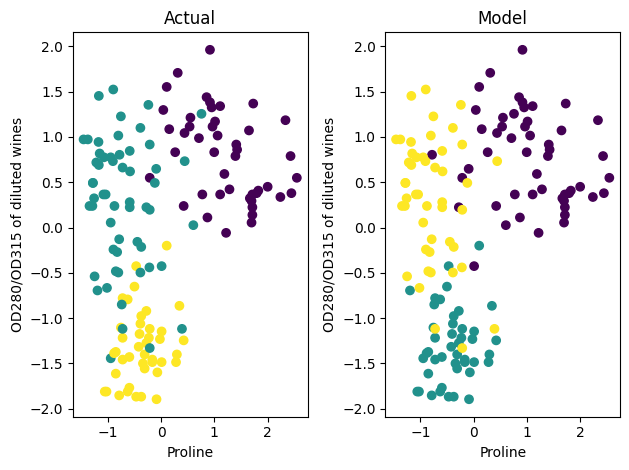

In [22]:
# Actual labels 
plt.subplot(1,2,1)
plt.scatter(X_train[:, 12], X_train[:, 11], c=y_train)
plt.ylabel("OD280/OD315 of diluted wines")
plt.xlabel("Proline")
plt.title("Actual")

# Model Identified Cluster's labels 
plt.subplot(1,2,2)
plt.scatter(X_train[:, 12], X_train[:, 11], c=kmeans.labels_)
plt.ylabel("OD280/OD315 of diluted wines")
plt.xlabel("Proline")
plt.title("Model")

plt.tight_layout()
plt.show()

From the graphs, we can see there's a few points (5) that are incorrectly labelled due to overlapping in our data, but it gives reasonably accurate clusters. A silhouette score may give additional insight, despite no visualisation.

In [23]:
# Evaluation of Model Using the Silhouette Score

score = silhouette_score(X_train, kmeans.labels_)
print(f"Silouette Score: {score}")

Silouette Score: 0.2745852962457017


The model score is somewhat accurate to what was identified using PCA. It identifies clusters, as we have already seen, but they are not well separated and have some overlap, which may be due to cultivar 2 in particular. As a result, it may have inaccuracies, as we could see with the five incorrect datapoints above. We will see how well the model performs with unseen data and compare its predictions to the actual data. 

### K-Means Predictions

- Visualisation of predictions compared to actual data using train-test split

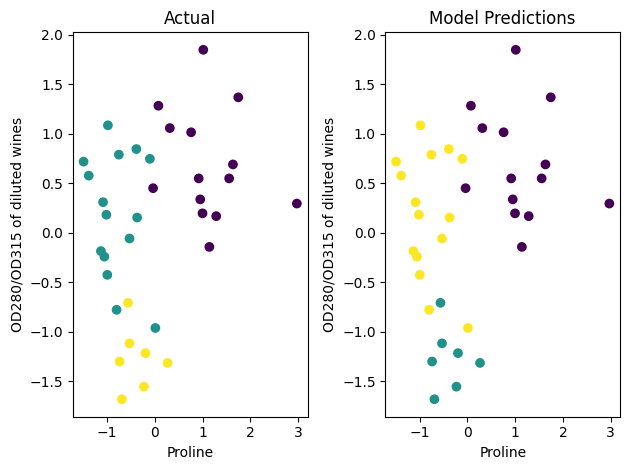

In [24]:
# Model Predictions 
kmeans_predictions = kmeans.predict(X_test)

# Graph ofo Actual Data
plt.subplot(1,2,1)
plt.scatter(X_test[:, 12], X_test[:, 11], c=y_test)
plt.ylabel("OD280/OD315 of diluted wines")
plt.xlabel("Proline")
plt.title("Actual")

# Graph of Predicted Data
plt.subplot(1,2,2)
plt.scatter(X_test[:, 12], X_test[:, 11], c=kmeans_predictions)
plt.ylabel("OD280/OD315 of diluted wines")
plt.xlabel("Proline")
plt.title("Model Predictions")

plt.tight_layout()
plt.show()

Looking at the test data and the predictions by the model, it actually performs really well. According to the graph, it is 100% accurate, performing as well as the k-nearest-neighbour model with the train-test split. However, this may not be accurate. As we have seen in the other models, the train-test split has performed better than our other evaluation techniques, so this may not be any different. Additionally, we know the clusters are not 100% accurate, unlike our predictions. Therefore, we cannot put too much confidence in this model. 

Having said that, for this dataset, it is not really appropriate to use this model. We know the correct labels so it would make more sense to use a supervised model. If we were provided with a dataset containing unlabelled data, this tells us that it would be reasonable to apply this model and it would be decently accurate. It could be more useful for sorting wines or drawing comparisons between them, rather than identifying precisely where it is from. For the objective of this notebook, that is not what we want to do.  

# Conclusion

Clearly, this data is quite limited. Much more data needs to be collected from a wide variety of cultivars to be effective. However, with this limited dataset, we can see that several models are effective for identifying the correct cultivar, with the best performing being the 7-nearest-neighbour model, achieving about 96-97% accuracy (as well as the k-means clustering model, although it is not as appropriate for this problem). Despite this, there is still room for improvement. 97% is of course not 100% (despite what the train-test split will have us believe). The models presented here are rather basic, so better solutions with even better accuracy are possible. For example, we may improve upon our 7NN model by reducing the number of outliers in our data. In comparison to a paper by Yuan Jiang and Zhi-Hua Zhou[5], which features a 3-nearest-neighbour on this dataset (3 was chosen to be consistent across multiple other datasets featured too), similar results were found, although slightly worse at between 94%-96%. Improvements were made to their results by applying several algorithms before hand to limit the effect of outliers. Applying these algorithms to our 7NN model may have yielded even better results as we identified some outliers within our data that may have led to the inaccuracies.    

 An additional issue may arise when we would expand our data to have wines come from many different countries to better answer the proposed question. Perhaps the data would not be so clear, especially with the attributes given here. As detailed by Magdalena Gajek et al. [3], there are methods of identifying the origins of wines using metals and minerals, such as higher levels of uranium in American wines, which would be useful to include in future analysis. Unfortunately, this dataset only included magnesium, and did not appear to be particularly useful. Another paper, by Nattane Luíza da Costa et al. [2], uses other chemical properties of wines to identify the wine's country of origin. Featuring wines from Argentina, Chile, Uruguay and Brazil, the paper compared the compounds catechin, gallic, octanoic acid, myricetin, caffeic, isobutanol, resveratrol, kaempferol, and ORAC found in each wine, after reducing that from 190 chemical variables. The resulting analysis, reduction in data and implementation of their SVM achieved a 93.97% accuracy. 

 Ultimately, can machine learning be applied to chemical analysis of wine to identify where it was produced? With the evidence shown in this notebook and additional research into this, machine learning is undoubtedly an effective solution, particularly a K-nearest-neighbour model, for identifying wines. Research by others has shown evidence of accurate models to identify the country of origin and the models used in this notebook show a good indication of being capable of identifying wines even from within the same region. However, these are relatively small in scale to the myriads of cultivars and wines out there. Further research will need to be done using a much larger dataset, using wines from multiple countries, which might reveal challenges with using our current machine learning strategies. This will allow for the models to be tuned more effectively and perhaps even better ones explored.  

# Bibliography/References

[1] Forina, M. et al. (1991). Wine Data Set [https://archive.ics.uci.edu/ml/datasets/Wine]. Genoa, Italy: Insitute of Pharmaceutical and Food Analysis and Technologies.

[2]	Nattane Luíza da Costa, Leonardo A. Valentin, Inar Alves Castro, and Rommel Melgaço Barbosa. 2021. Predictive modeling for wine authenticity using a machine learning approach. Artificial Intelligence in Agriculture 5, (2021), 157–162. DOI:https://doi.org/10.1016/j.aiia.2021.07.001

[3]	Magdalena Gajek, Aleksandra Pawlaczyk, and Malgorzata I. Szynkowska-Jozwik. 2021. Multi-Elemental Analysis of Wine Samples in Relation to Their Type, Origin, and Grape Variety. Molecules 26, 1 (January 2021), 214. DOI:https://doi.org/10.3390/molecules26010214

[4]	Holmberg. 2010. Wine fraud. IJWR (October 2010), 105. DOI:https://doi.org/10.2147/IJWR.S14102

[5]	Yuan Jiang and Zhi-Hua Zhou. 2004. Editing Training Data for kNN Classifiers with Neural Network Ensemble. In Advances in Neural Networks – ISNN 2004, Fu-Liang Yin, Jun Wang and Chengan Guo (eds.). Springer Berlin Heidelberg, Berlin, Heidelberg, 356–361. DOI:https://doi.org/10.1007/978-3-540-28647-9_60

[6] Randox Food Diagnostics. 2019. Why is testing for L-Malic Acid important in winemaking? Link: https://www.randoxfood.com/why-is-testing-for-l-malic-acid-important-in-winemaking

[7] Nierman, Doug. 2004. Acidity is a fundamental property of wine, imparting sourness and resistance to microbial infection. Link: https://waterhouse.ucdavis.edu/whats-in-wine/fixed-acidity

[8] Reiss, Stephen. Wine Education. What (Red) Wine is Made Of. Link: http://www.wineeducation.com/wineismadeof.html

[9] Heidger Michael. 2015. Ash (gravitmetric, calculated from minerals, alkalinity of ach). Insitut Heidger. Link: https://www.institut-heidger.de/ash-gravimetric-calculated-from-minerals-alkalinity-of-ash/?lang=en

[10] Magnesium in Beer and Wine. 1995. Link: http://www.mgwater.com/beer.shtml

[11] Waterhouse, Andrew L. 2006. Wine Phenolics. Annals of the New York Academy of Sciences. Volume 957, Issue 1, p.21-36. DOI: https://doi.org/10.1111/j.1749-6632.2002.tb02903.x

[12] Puckette, Madelaine. Secrets Behind the Color Pigment in Red Wine. Link: https://winefolly.com/deep-dive/know-a-wine-just-by-looking-at-the-color/

[13] Xueting Bai, Lingbo Wang, and Hanning Li. Identification of red wine categories based on physicochemical properties. Link: https://webofproceedings.org/proceedings_series/ESSP/ETMHS%202019/ETMHS19309.pdf